## Fine-tuning pre-trained ViTs and evaluating them on the LIDC-IDRI dataset.

In [2]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pickle
import torch
from torchvision import transforms
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import numpy as np
from typing import Optional, Dict
from prettytable import PrettyTable

In [5]:
%load_ext autoreload
%autoreload 2
    
from my_utils.plot_utils import plot_hists
from my_utils.norm_factors import compute_norm_factors
from End2End_Model import End2End_Model
from Biomarker_Model import Biomarker_Model
from LIDC_DataModule import DataModule

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dividing dataset into three sets: training, validation and test sets.

In [6]:
# Paths
local = False
if local:
    datapath = "/home/jbinda/INFORM/LIDC/dataset/"
    subsets_saving_path = "/home/jbinda/INFORM/LIDC_ViTs/dataset/splitted_sets/"
    checkpoints_path="/home/jbinda/INFORM/LIDC_ViTs/ckpt/"
    Path(subsets_saving_path).mkdir(parents=True, exist_ok=True)
else:
    datapath = "/home/dzban112/LIDC_ViTs/dataset/"
    subsets_saving_path = "/home/dzban112/LIDC_ViTs/dataset/splitted_sets/"
    checkpoints_path="/home/dzban112/LIDC_ViTs/ckpt/"
    Path(subsets_saving_path).mkdir(parents=True, exist_ok=True)

In [7]:
#Reading all annotations and extracting paths, target: benign, malignant.
df = pd.read_pickle(f"{datapath}/ALL_annotations_df.pkl")

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
folds = skf.split(X=df["path"], y=df["target"])

In [9]:
for i, (train_indices, test_indices) in enumerate(folds):
    with open(subsets_saving_path+f"train_fold_{i+1}.pkl", 'wb') as file:
        pickle.dump(list(train_indices), file)
    with open(subsets_saving_path+f"test_fold_{i+1}.pkl", 'wb') as file:
        pickle.dump(list(test_indices), file)

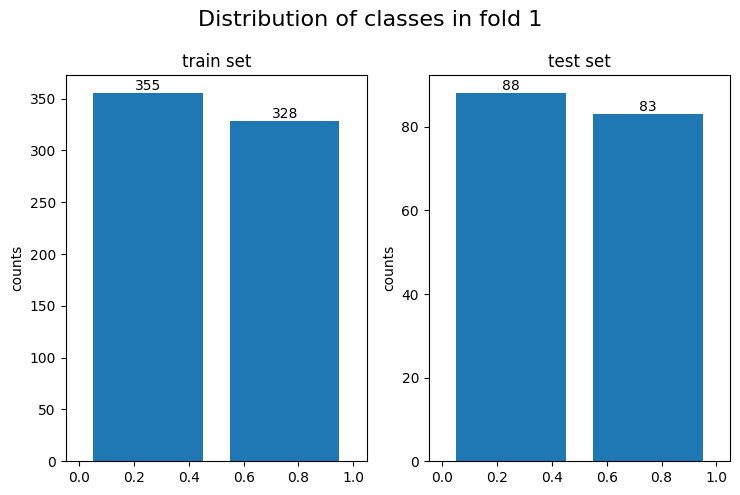

In [10]:
plot_hists(fold=1, datapath=datapath, subsets_saving_path=subsets_saving_path)

### Computing Normalization Factors

In [11]:
def prepare_norm_factors(n_splits=5):
    df = pd.read_pickle(f"{datapath}/ALL_annotations_df.pkl")
    fitted_factors = {}
    for fold in range(1, n_splits+1):
        # Computing mean and std of image pixels values.
        with open(datapath+f"/splitted_sets/train_fold_{fold}.pkl", 'rb') as file:
            train_indices = pickle.load(file)
            X_train = df.iloc[train_indices]["path"]
            mean, std = compute_norm_factors(X_train, datapath)
            
            # Creating instance of biomarker scaler
            biomarkers = df.iloc[train_indices][["subtlety", "calcification",
                                                 "margin", "lobulation",
                                                 "spiculation", "diameter",
                                                 "texture", "sphericity"]].to_numpy() #without targets
            scaler = StandardScaler().fit(biomarkers)

            # Saving in dictionary object:
            fitted_factors[f"fold_{fold}"] = (mean, std, scaler)
        

    with open(subsets_saving_path+"/"+"fitted_factors.pkl", 'wb') as f:
        pickle.dump(fitted_factors, f)
    
    return fitted_factors

fitted_factors = prepare_norm_factors(n_splits=5)

print(fitted_factors["fold_1"][0:2])
print(fitted_factors["fold_2"][0:2])
print(fitted_factors["fold_3"][0:2])
print(fitted_factors["fold_4"][0:2])
print(fitted_factors["fold_5"][0:2])

(tensor(-635.5035), tensor(357.7024))
(tensor(-630.2654), tensor(359.1476))
(tensor(-629.6009), tensor(363.2001))
(tensor(-637.0364), tensor(353.1784))
(tensor(-633.3669), tensor(357.5357))


## Fine-tuning End2End Model

Finetuning was performed with GPU accelaration. To train model I have used python script `train_End2End.py`.
Using first fold I have searched for the best hyperparameters and hyperparameters yielding the best model, were used to train model on five folds.

## End2End model evaluation on validation sets

In [10]:
def E2E_model_evaluation(model_name:str, version:Optional[str]=None):
    res={}
    for fold in range(1,6):
        print(f"fold: {fold}")
        dm = DataModule(
            fold=fold,
            datapath=datapath,
            batch_size=16,
            num_workers=8,
            task="Classification"
        )

        if version is None:
            ckpt_path = checkpoints_path+"End2End/"+model_name+f"_{fold}"+".ckpt"
        else:
            ckpt_path = checkpoints_path+"End2End/"+model_name+f"_{fold}"+f"-{version}"+".ckpt"
        model = End2End_Model.load_from_checkpoint(ckpt_path)
        torch.set_float32_matmul_precision('medium')
        trainer = pl.Trainer(accelerator="gpu", devices=1, precision=32, logger=False)
        model.eval()
        res[f"fold_{fold}"] = trainer.test(model, dm)
    return res


def compute_results(raw_results:Dict[str, list]):
    ACC = []
    folds = []
    mean_ACC = 0
    n = 0
    for fold in raw_results.keys():
        cur_ACC = raw_results[fold][0]["val_acc"]
        ACC.append(cur_ACC)
        folds.append(f"Fold {fold}")
        mean_ACC += cur_ACC
        n += 1
    mean_ACC = mean_ACC/n

    df = pd.DataFrame({"Fold": folds, "Accuracy": ACC})
    df.loc[len(df)] = ['Mean Accuracy', mean_ACC]
    
    table = PrettyTable()
    table.field_names = df.columns.tolist()

    for row in df.itertuples(index=False):
        table.add_row(row)

    for field in df.columns:
        table.align[field] = 'l'
    
    return table

#### DINO_vitb8

In [ ]:
# dino_vitb8_38 - version 0
res = E2E_model_evaluation(model_name="dino_vitb8_38")

In [8]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.9239766001701355 |
| Fold fold_3   | 0.8947368264198303 |
| Fold fold_4   | 0.9005848169326782 |
| Fold fold_5   | 0.8823529481887817 |
| Mean Accuracy | 0.9016167879104614 |
+---------------+--------------------+


In [ ]:
# dino_vitb8_38 - version v1
res = E2E_model_evaluation(model_name="dino_vitb8_38", version="v1")

In [14]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8947368264198303 |
| Fold fold_2   | 0.9005848169326782 |
| Fold fold_3   | 0.9122806787490845 |
| Fold fold_4   | 0.8654970526695251 |
| Fold fold_5   | 0.8705882430076599 |
| Mean Accuracy | 0.8887375235557556 |
+---------------+--------------------+


In [ ]:
# dino_vitb8_38 - version v2
res = E2E_model_evaluation(model_name="dino_vitb8_38", version="v2")

In [12]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8830409646034241 |
| Fold fold_2   | 0.9005848169326782 |
| Fold fold_3   | 0.9122806787490845 |
| Fold fold_4   | 0.8771929740905762 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.8922669410705566 |
+---------------+--------------------+


#### DINO_vits8

In [ ]:
# dino_vits8_39 - version 0
res = E2E_model_evaluation(model_name="dino_vits8_39")

In [16]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8888888955116272 |
| Fold fold_2   | 0.9181286692619324 |
| Fold fold_3   | 0.8888888955116272 |
| Fold fold_4   | 0.8830409646034241 |
| Fold fold_5   | 0.8764705657958984 |
| Mean Accuracy | 0.8910835981369019 |
+---------------+--------------------+


In [ ]:
# dino_vits8_39 - version v1
res = E2E_model_evaluation(model_name="dino_vits8_39", version="v1")

In [18]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9122806787490845 |
| Fold fold_2   | 0.9064327478408813 |
| Fold fold_3   | 0.8888888955116272 |
| Fold fold_4   | 0.9181286692619324 |
| Fold fold_5   | 0.8588235378265381 |
| Mean Accuracy | 0.8969109058380127 |
+---------------+--------------------+


In [ ]:
# dino_vits8_39 - version v2
res = E2E_model_evaluation(model_name="dino_vits8_39", version="v2")

In [20]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8421052694320679 |
| Fold fold_2   | 0.9064327478408813 |
| Fold fold_3   | 0.9005848169326782 |
| Fold fold_4   | 0.9005848169326782 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.8875885844230652 |
+---------------+--------------------+


#### DINO_vits16

In [ ]:
# dino_vits16_32 - version 0
res = E2E_model_evaluation(model_name="dino_vits16_32")

In [21]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9005848169326782 |
| Fold fold_2   | 0.8654970526695251 |
| Fold fold_3   | 0.871345043182373  |
| Fold fold_4   | 0.9005848169326782 |
| Fold fold_5   | 0.8941176533699036 |
| Mean Accuracy | 0.8864258766174317 |
+---------------+--------------------+


In [ ]:
# dino_vits16_32 - version v1
res = E2E_model_evaluation(model_name="dino_vits16_32", version="v1")

In [17]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.9005848169326782 |
| Fold fold_3   | 0.8888888955116272 |
| Fold fold_4   | 0.871345043182373  |
| Fold fold_5   | 0.8941176533699036 |
| Mean Accuracy | 0.8922738313674927 |
+---------------+--------------------+


In [ ]:
# dino_vits16_32 - version v2
res = E2E_model_evaluation(model_name="dino_vits16_32", version="v2")

In [23]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9239766001701355 |
| Fold fold_2   | 0.8830409646034241 |
| Fold fold_3   | 0.8654970526695251 |
| Fold fold_4   | 0.871345043182373  |
| Fold fold_5   | 0.8823529481887817 |
| Mean Accuracy | 0.8852425217628479 |
+---------------+--------------------+


#### DINO_vitb16

In [ ]:
# dino_vitb16_35 - version 0
res = E2E_model_evaluation(model_name="dino_vitb16_35")

In [8]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8888888955116272 |
| Fold fold_2   | 0.9122806787490845 |
| Fold fold_3   | 0.859649121761322  |
| Fold fold_4   | 0.9181286692619324 |
| Fold fold_5   | 0.8999999761581421 |
| Mean Accuracy | 0.8957894682884217 |
+---------------+--------------------+


In [ ]:
# dino_vitb16_35 - version v1
res = E2E_model_evaluation(model_name="dino_vitb16_35", version="v1")

In [10]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.8947368264198303 |
| Fold fold_3   | 0.859649121761322  |
| Fold fold_4   | 0.9239766001701355 |
| Fold fold_5   | 0.8823529481887817 |
| Mean Accuracy | 0.8934296488761901 |
+---------------+--------------------+


In [ ]:
# dino_vitb16_35 - version v2
res = E2E_model_evaluation(model_name="dino_vitb16_35", version="v2")

In [12]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9239766001701355 |
| Fold fold_2   | 0.8888888955116272 |
| Fold fold_3   | 0.8654970526695251 |
| Fold fold_4   | 0.8888888955116272 |
| Fold fold_5   | 0.8764705657958984 |
| Mean Accuracy | 0.8887444019317627 |
+---------------+--------------------+


#### DINOv2_vitb14

In [ ]:
# dinov2_vitb14_reg_1 - version 0
res = E2E_model_evaluation(model_name="dinov2_vitb14_reg_1")

In [7]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9181286692619324 |
| Fold fold_2   | 0.8888888955116272 |
| Fold fold_3   | 0.9181286692619324 |
| Fold fold_4   | 0.9064327478408813 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.9039628505706787 |
+---------------+--------------------+


In [ ]:
# dinov2_vitb14_reg_1 - version v1
res = E2E_model_evaluation(model_name="dinov2_vitb14_reg_1", version="v1")

In [10]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8830409646034241 |
| Fold fold_2   | 0.8947368264198303 |
| Fold fold_3   | 0.8888888955116272 |
| Fold fold_4   | 0.9122806787490845 |
| Fold fold_5   | 0.8705882430076599 |
| Mean Accuracy | 0.8899071216583252 |
+---------------+--------------------+


In [ ]:
# dinov2_vitb14_reg_1 - version v2
res = E2E_model_evaluation(model_name="dinov2_vitb14_reg_1", version="v2")

In [12]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8888888955116272 |
| Fold fold_2   | 0.8947368264198303 |
| Fold fold_3   | 0.9064327478408813 |
| Fold fold_4   | 0.8888888955116272 |
| Fold fold_5   | 0.8999999761581421 |
| Mean Accuracy | 0.8957894682884217 |
+---------------+--------------------+


#### DINOv2_vits14_reg_4

In [ ]:
# dinov2_vits14_reg_4 - version 0
res = E2E_model_evaluation(model_name="dinov2_vits14_reg_4")

In [14]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9005848169326782 |
| Fold fold_2   | 0.9122806787490845 |
| Fold fold_3   | 0.8771929740905762 |
| Fold fold_4   | 0.9064327478408813 |
| Fold fold_5   | 0.8764705657958984 |
| Mean Accuracy | 0.8945923566818237 |
+---------------+--------------------+


In [ ]:
# dinov2_vits14_reg_4 - version v1
res = E2E_model_evaluation(model_name="dinov2_vits14_reg_4", version="v1")

In [16]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.8947368264198303 |
| Fold fold_3   | 0.8947368264198303 |
| Fold fold_4   | 0.9181286692619324 |
| Fold fold_5   | 0.8705882430076599 |
| Mean Accuracy | 0.8969246625900269 |
+---------------+--------------------+


In [ ]:
# dinov2_vits14_reg_4 - version v2
res = E2E_model_evaluation(model_name="dinov2_vits14_reg_4", version="v2")

In [18]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.8947368264198303 |
| Fold fold_2   | 0.8830409646034241 |
| Fold fold_3   | 0.8830409646034241 |
| Fold fold_4   | 0.9122806787490845 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.8922669410705566 |
+---------------+--------------------+


#### SL ViTb16

In [ ]:
# vitb16_9 - version 0
res = E2E_model_evaluation(model_name="vit_b_16_9")

In [27]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.8947368264198303 |
| Fold fold_3   | 0.9005848169326782 |
| Fold fold_4   | 0.8888888955116272 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.8957757115364074 |
+---------------+--------------------+


In [ ]:
# vitb16_9 - version v1
res = E2E_model_evaluation(model_name="vit_b_16_9", version="v1")

In [29]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9064327478408813 |
| Fold fold_2   | 0.8830409646034241 |
| Fold fold_3   | 0.9005848169326782 |
| Fold fold_4   | 0.9005848169326782 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.8957757234573365 |
+---------------+--------------------+


In [ ]:
# vitb16_9 - version v2
res = E2E_model_evaluation(model_name="vit_b_16_9", version="v2")

In [31]:
results = compute_results(res)
print(results)

+---------------+--------------------+
| Fold          | Accuracy           |
+---------------+--------------------+
| Fold fold_1   | 0.9181286692619324 |
| Fold fold_2   | 0.9005848169326782 |
| Fold fold_3   | 0.8947368264198303 |
| Fold fold_4   | 0.9181286692619324 |
| Fold fold_5   | 0.8882352709770203 |
| Mean Accuracy | 0.9039628505706787 |
+---------------+--------------------+


## Fine-tuning biomarker regression model

Finetuning was performed with GPU accelaration. To train model I have used python script `train_biomarker.py`.
Using first fold I have searched for the best hyperparameters and hyperparameters yielding the best model, were used to train model on five folds.

## Biomarker Model evaluation on validation sets

In [19]:
def biom_model_evaluation(model_name:str, version:Optional[str]=None):
    res={}
    for fold in range(1,6):
        print(f"fold: {fold}")
        dm = DataModule(
            fold=fold,
            datapath=datapath,
            batch_size=16,
            num_workers=8,
            task="Regression"
        )

        if version is None:
            ckpt_path = checkpoints_path+"Biomarkers/"+model_name+f"_{fold}"+".ckpt"
        else:
            ckpt_path = checkpoints_path+"Biomarkers/"+model_name+f"_{fold}"+f"-{version}"+".ckpt"
        model = Biomarker_Model.load_from_checkpoint(ckpt_path)
        torch.set_float32_matmul_precision('medium')
        trainer = pl.Trainer(accelerator="gpu", devices=1, precision=32, logger=False)
        model.eval()
        res[f"fold_{fold}"] = trainer.test(model, dm)
    return res


def compute_biom_results(raw_results:Dict[str, list]):
    MSE = []
    RMSE = []
    folds = []
    mean_MSE = 0
    mean_RMSE = 0
    n = 0
    for fold in raw_results.keys():
        cur_MSE = raw_results[fold][0]["val_mse"]
        cur_RMSE = raw_results[fold][0]["val_rmse"]
        MSE.append(cur_MSE)
        RMSE.append(cur_RMSE)
        folds.append(f"Fold {fold}")
        mean_MSE += cur_MSE
        mean_RMSE += cur_RMSE
        n += 1
    mean_MSE = mean_MSE/n
    mean_RMSE = mean_RMSE/n

    df = pd.DataFrame({"Fold": folds, "MSE": MSE, "RMSE": RMSE})
    df.loc[len(df)] = ['Mean', mean_MSE, mean_RMSE]
    
    table = PrettyTable()
    table.field_names = df.columns.tolist()

    for row in df.itertuples(index=False):
        table.add_row(row)

    for field in df.columns:
        table.align[field] = 'l'
    
    return table

#### DINO_vits8

In [ ]:
# dino_vits8_20 - version 0
res = biom_model_evaluation(model_name="dino_vits8_20")

In [27]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.47772809863090515 | 0.6838443875312805 |
| Fold fold_2 | 0.4925924241542816  | 0.6967159509658813 |
| Fold fold_3 | 0.4817977845668793  | 0.6909966468811035 |
| Fold fold_4 | 0.437734991312027   | 0.657689094543457  |
| Fold fold_5 | 0.4804145395755768  | 0.6858134269714355 |
| Mean        | 0.47405356764793394 | 0.6830119013786315 |
+-------------+---------------------+--------------------+


In [ ]:
# dino_vits8_20 - version v1
res = biom_model_evaluation(model_name="dino_vits8_20", version="v1")

In [29]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.46627411246299744 | 0.6764076948165894 |
| Fold fold_2 | 0.48672375082969666 | 0.6917068958282471 |
| Fold fold_3 | 0.47457051277160645 | 0.6858831644058228 |
| Fold fold_4 | 0.4468400776386261  | 0.6648386716842651 |
| Fold fold_5 | 0.48623496294021606 | 0.6912744045257568 |
| Mean        | 0.47212868332862856 | 0.6820221662521362 |
+-------------+---------------------+--------------------+


In [ ]:
# dino_vits8_20 - version v2
res = biom_model_evaluation(model_name="dino_vits8_20", version="v2")

In [31]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.47864189743995667 | 0.6841988563537598 |
| Fold fold_2 | 0.5027711391448975  | 0.7041217088699341 |
| Fold fold_3 | 0.4644819498062134  | 0.6785911321640015 |
| Fold fold_4 | 0.44567278027534485 | 0.6636403799057007 |
| Fold fold_5 | 0.48993876576423645 | 0.6939759254455566 |
| Mean        | 0.4763013064861298  | 0.6849056005477905 |
+-------------+---------------------+--------------------+


#### DINO_vitb8

In [ ]:
# dino_vitb8_22 - version 0
res = biom_model_evaluation(model_name="dino_vitb8_22")

In [33]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.4548805058002472  | 0.6630585193634033 |
| Fold fold_2 | 0.431853711605072   | 0.6501020789146423 |
| Fold fold_3 | 0.42006585001945496 | 0.6449114680290222 |
| Fold fold_4 | 0.40646445751190186 | 0.6336378455162048 |
| Fold fold_5 | 0.40543287992477417 | 0.6314957737922668 |
| Mean        | 0.42373948097229003 | 0.6446411371231079 |
+-------------+---------------------+--------------------+


In [ ]:
# dino_vitb8_22 - version v1
res = biom_model_evaluation(model_name="dino_vitb8_22", version="v1")

In [35]:
results = compute_biom_results(res)
print(results)

+-------------+--------------------+--------------------+
| Fold        | MSE                | RMSE               |
+-------------+--------------------+--------------------+
| Fold fold_1 | 0.4477558135986328 | 0.6606637835502625 |
| Fold fold_2 | 0.4270491898059845 | 0.6478157043457031 |
| Fold fold_3 | 0.4170427918434143 | 0.6431949734687805 |
| Fold fold_4 | 0.4030633568763733 | 0.6321068406105042 |
| Fold fold_5 | 0.4004560112953186 | 0.6284404993057251 |
| Mean        | 0.4190734326839447 | 0.6424443602561951 |
+-------------+--------------------+--------------------+


In [ ]:
# dino_vitb8_22 - version v2
res = biom_model_evaluation(model_name="dino_vitb8_22", version="v2")

In [37]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.4480020999908447  | 0.6606625318527222 |
| Fold fold_2 | 0.4396868646144867  | 0.6572553515434265 |
| Fold fold_3 | 0.42537322640419006 | 0.6493530869483948 |
| Fold fold_4 | 0.3977943956851959  | 0.6271524429321289 |
| Fold fold_5 | 0.40917542576789856 | 0.6344937682151794 |
| Mean        | 0.4240064024925232  | 0.6457834362983703 |
+-------------+---------------------+--------------------+


#### DINO_vits16

In [ ]:
# dino_vits16_21 - version 0
res = biom_model_evaluation(model_name="dino_vits16_21")

In [39]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.49294963479042053 | 0.6982766389846802 |
| Fold fold_2 | 0.5367931723594666  | 0.7286670207977295 |
| Fold fold_3 | 0.46141350269317627 | 0.6767612099647522 |
| Fold fold_4 | 0.470838725566864   | 0.6825510263442993 |
| Fold fold_5 | 0.49312978982925415 | 0.6954806447029114 |
| Mean        | 0.4910249650478363  | 0.6963473081588745 |
+-------------+---------------------+--------------------+


In [ ]:
# dino_vits16_21 - version v1
res = biom_model_evaluation(model_name="dino_vits16_21", version="v1")

In [41]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.5102280378341675  | 0.7090757489204407 |
| Fold fold_2 | 0.5190607905387878  | 0.7162201404571533 |
| Fold fold_3 | 0.4497787356376648  | 0.6675020456314087 |
| Fold fold_4 | 0.46578091382980347 | 0.6788238883018494 |
| Fold fold_5 | 0.49255266785621643 | 0.6955915093421936 |
| Mean        | 0.487480229139328   | 0.6934426665306092 |
+-------------+---------------------+--------------------+


In [ ]:
# dino_vits16_21 - version v2
res = biom_model_evaluation(model_name="dino_vits16_21", version="v2")

In [43]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.4972267746925354  | 0.7007282376289368 |
| Fold fold_2 | 0.5260489583015442  | 0.721137523651123  |
| Fold fold_3 | 0.44932350516319275 | 0.6678690910339355 |
| Fold fold_4 | 0.4724162518978119  | 0.6823030710220337 |
| Fold fold_5 | 0.49456363916397095 | 0.6974434852600098 |
| Mean        | 0.48791582584381105 | 0.6938962817192078 |
+-------------+---------------------+--------------------+


#### DINO_vitb16

In [ ]:
# dino_vitb16_23 - version 0
res = biom_model_evaluation(model_name="dino_vitb16_23")

In [45]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.4608401358127594  | 0.6715735793113708 |
| Fold fold_2 | 0.46194809675216675 | 0.6742401123046875 |
| Fold fold_3 | 0.42323508858680725 | 0.6471384167671204 |
| Fold fold_4 | 0.38727903366088867 | 0.6189811825752258 |
| Fold fold_5 | 0.44304144382476807 | 0.6589334607124329 |
| Mean        | 0.435268759727478   | 0.6541733503341675 |
+-------------+---------------------+--------------------+


In [ ]:
# dino_vitb16_23 - version v1
res = biom_model_evaluation(model_name="dino_vitb16_23", version="v1")

In [47]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.4586869478225708  | 0.670350193977356  |
| Fold fold_2 | 0.4612713158130646  | 0.6737255454063416 |
| Fold fold_3 | 0.4214211106300354  | 0.6458151340484619 |
| Fold fold_4 | 0.38610562682151794 | 0.6180040836334229 |
| Fold fold_5 | 0.4385327994823456  | 0.6557394862174988 |
| Mean        | 0.43320356011390687 | 0.6527268886566162 |
+-------------+---------------------+--------------------+


In [ ]:
# dino_vitb16_23 - version v2
res = biom_model_evaluation(model_name="dino_vitb16_23", version="v2")

In [49]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.4523272216320038  | 0.665888249874115  |
| Fold fold_2 | 0.4372449219226837  | 0.6554130911827087 |
| Fold fold_3 | 0.41876962780952454 | 0.6437686085700989 |
| Fold fold_4 | 0.3852725923061371  | 0.6172862648963928 |
| Fold fold_5 | 0.44119030237197876 | 0.6581307053565979 |
| Mean        | 0.42696093320846557 | 0.6480973839759827 |
+-------------+---------------------+--------------------+


#### SL ViTb16

In [ ]:
# vit_b_16_24 - version 0
res = biom_model_evaluation(model_name="vit_b_16_24")

In [51]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.4219968914985657  | 0.6414162516593933 |
| Fold fold_2 | 0.4275776743888855  | 0.6475473046302795 |
| Fold fold_3 | 0.3998645842075348  | 0.6286083459854126 |
| Fold fold_4 | 0.38622865080833435 | 0.6184868216514587 |
| Fold fold_5 | 0.4048093855381012  | 0.630445122718811  |
| Mean        | 0.4080954372882843  | 0.6333007693290711 |
+-------------+---------------------+--------------------+


In [ ]:
# vit_b_16_24 - version v1
res = biom_model_evaluation(model_name="vit_b_16_24", version="v1")

In [53]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.42907193303108215 | 0.6445633769035339 |
| Fold fold_2 | 0.41226789355278015 | 0.6368703842163086 |
| Fold fold_3 | 0.40877029299736023 | 0.6356061697006226 |
| Fold fold_4 | 0.38617587089538574 | 0.6181685328483582 |
| Fold fold_5 | 0.3927106559276581  | 0.6209197640419006 |
| Mean        | 0.40579932928085327 | 0.6312256455421448 |
+-------------+---------------------+--------------------+


In [ ]:
# vit_b_16_24 - version v2
res = biom_model_evaluation(model_name="vit_b_16_24", version="v2")

In [55]:
results = compute_biom_results(res)
print(results)

+-------------+---------------------+--------------------+
| Fold        | MSE                 | RMSE               |
+-------------+---------------------+--------------------+
| Fold fold_1 | 0.4304415285587311  | 0.6456624269485474 |
| Fold fold_2 | 0.41659653186798096 | 0.6385087370872498 |
| Fold fold_3 | 0.4193733036518097  | 0.6435497999191284 |
| Fold fold_4 | 0.38416606187820435 | 0.6162351965904236 |
| Fold fold_5 | 0.39789634943008423 | 0.6250723600387573 |
| Mean        | 0.4096947550773621  | 0.6338057041168212 |
+-------------+---------------------+--------------------+
